# Programmer: Giovanni Vecchione
## Date: 3/8/24
## Subject: Project 3
Use convolutional neural network to build the project on the dataset of your choice. Submit your project as Jupyter notebook.

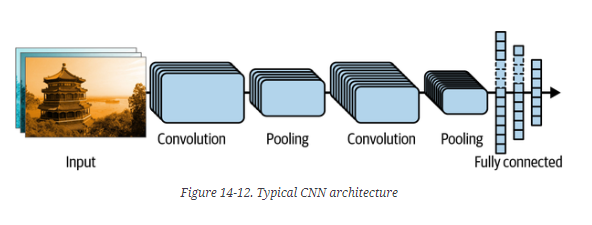



In [6]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

#import and preprocess sample images using Scikit-Learn's load_sample_image() funciton
#and Keras's CenterCrop and Rescaling layers.
images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

images.shape

TensorShape([2, 70, 120, 3])

In [20]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

fmaps.shape

TensorShape([2, 70, 120, 32])

^^The output shape is similar to the input shape, with two main differences. First, there are 32 channels instead of 3. This is because we set filters=32, so we get 32 output feature maps: instead of the intensity of red, green, and blue at each location, we now have the intensity of each feature at each location. Second, the height and width have both shrunk by 6 pixels. This is due to the fact that the Conv2D layer does not use any zero-padding by default, which means that we lose a few pixels on the sides of the output feature maps, depending on the size of the filters. In this case, since the kernel size is 7, we lose 6 pixels horizontally and 6 pixels vertically (i.e., 3 pixels on each side).

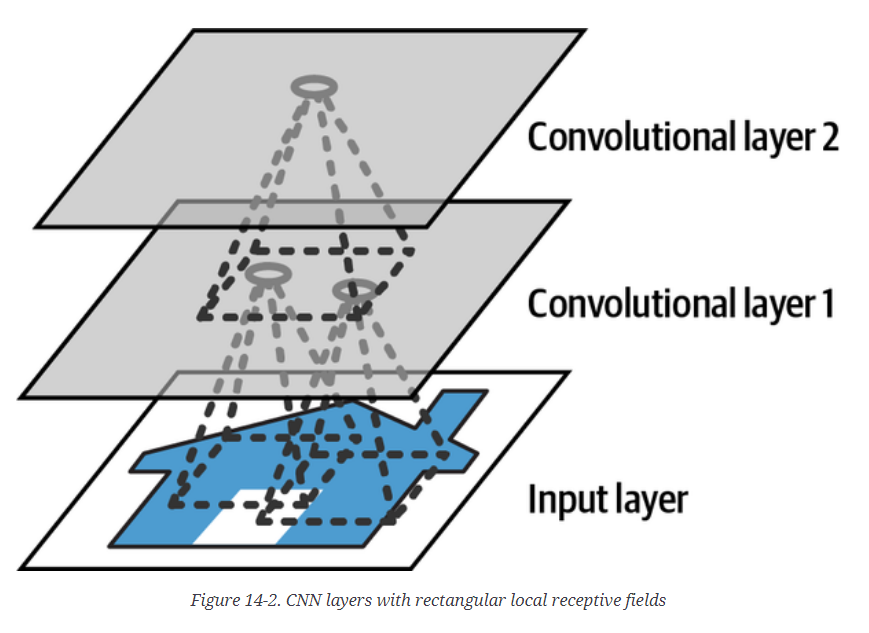

## Basic Hyperparameters: filters, kernel_size, padding, strides, activation, kernel_initializer, etc. 

# Filters:
Filters are small matrices of numbers (like a 3x3 or 5x5 grid). These numbers are the weights that get adjusted during the CNN's training process. They are trained to detect specific patterns within the input data. In image processing, these patterns might be edges, curves, textures, or even more complex features like eyes or noses.

# Padding:
Now the padding can be adjusted to adjust the size from one layer to another (input/output)

    "same" - inputs are padded with enough zeros on all sides to ensure that the output feature maps end up with the same size as the inputs.

    "valid" -  if the width of the input is ih, then the output width is equal to (ih - fh + sh) / sh, rounded down

# Weigths:
All the neurons in the output feature maps share the same weights, as explained earlier. This means that you can feed images of any size to this layer, as long as they are at least as large as the kernels, and if they have the right number of channels.

    Example:
    >>> kernels, biases = conv_layer.get_weights()
    >>> kernels.shape
    (7, 7, 3, 32)
    >>> biases.shape
    (32,)

# Activation Layers:
Lastly, you will generally want to specify an activation function (such as ReLU) when creating a Conv2D layer, and also specify the corresponding kernel initializer (such as He initialization).

# Pooling Layers: Used for Downsampling, Invariance, and Hierarchical Representation
The CNN downsamples the convolved feature (to save on processing time), reducing the number of dimensions of the feature map, while still preserving the most critical feature information. The primary goal is to reduce the size (width and height) of the feature maps created by convolutional layers. Common algorithms include:

    Max Pooling: Most popular due to its good empirical performance.
        ex. max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

    Average Pooling: Provides a smoother, averaged representation.
        ex. avg_pool = tf.keras.layers.AveragePooling2D(2, 2)
        
    Global Pooling: Pools an entire feature map into a single value, often used in the final layers before classification.
        ex. global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

We slide over the feature map and extract tiles of a specified size. For each tile, the maximum value is output to a new feature map, and all other values are discarded. Max pooling operations take two parameters:

    Size of the max-pooling filter (typically 2x2 pixels)
    Stride: the distance, in pixels, separating each extracted tile. 

There are downsides, invariance may not be desirable in certain situations.

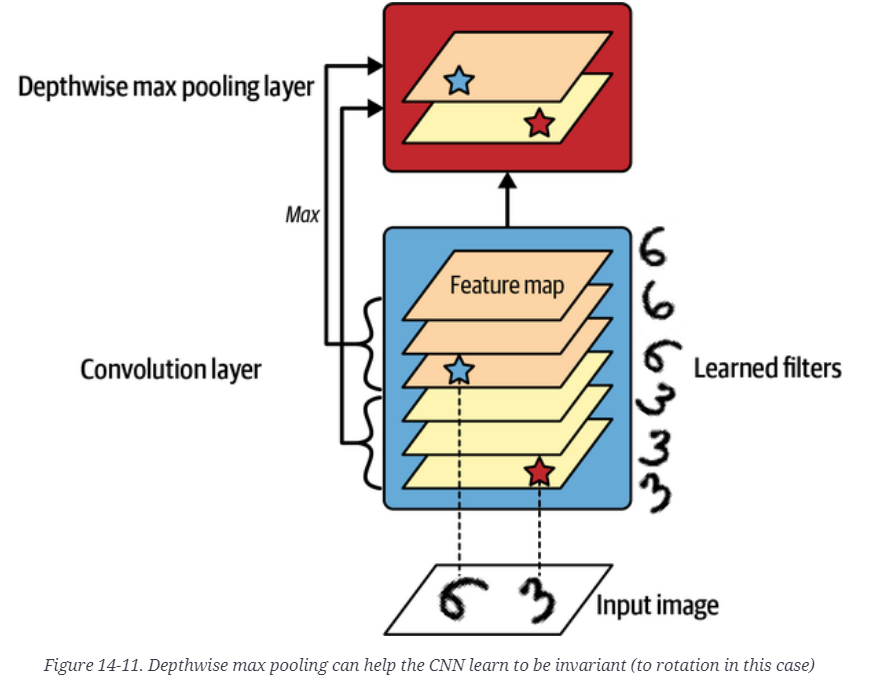

Add the padding attribute to adjust the output feature map outputs

In [21]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding = "same")
fmaps = conv_layer(images)

fmaps.shape
#Ends up with same size as the inputs

TensorShape([2, 70, 120, 32])

In [23]:
kernels, biases = conv_layer.get_weights()
kernels.shape
#The kernels array is 4D, and its shape is [kernel_height, kernel_width, input_channels, output_channels].

(7, 7, 3, 32)

In [24]:
biases.shape
#The biases array is 1D, with shape [output_channels]

(32,)

In [ ]:
#Keras does not include a depthwise max pooling layer, but it's not too difficult to implement a custom layer for that:

class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

# Basic CNN for the Fashion MNIST dataset

In [26]:
from functools import partial
import tensorflow as tf
import matplotlib as mpl

#FIGURE OUT HOW TO IMPORT AND SPLIT TRAINING AND TEST DATA 
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

X_train, y_train = X_train_full[:-2000], y_train_full[:-2000]
X_valid, y_valid = X_train_full[-2000:], y_train_full[-2000:]
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

tf.random.set_seed(42)
##This does not seem right^^^^^^^^^^^^^^^^

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer = "sgd", metrics=["accuracy"])

#This portion stops training using early_stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_70 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_71 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 7, 7, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 7, 7, 256)       

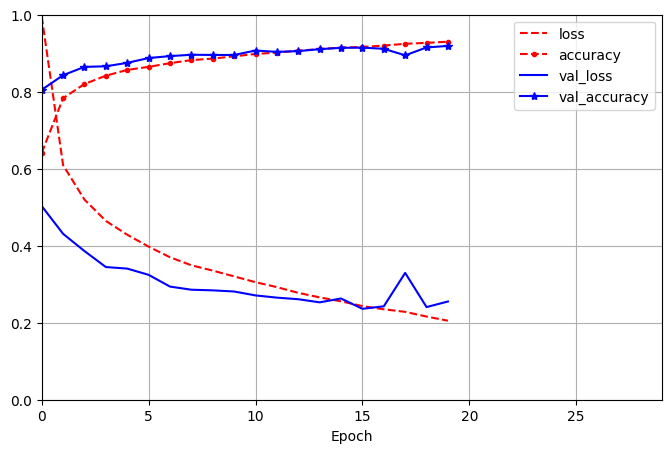

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [28]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_valid, y_valid)
print("Validation loss: {:.3f}, Validation accuracy: {:.3f}".format(val_loss, val_acc))

63/63 [==============================] - 1s 12ms/step - loss: 0.2551 - accuracy: 0.9190
Validation loss: 0.255, Validation accuracy: 0.919


## Test 1:
Time: 21 min

    Training:
        Epoch 20/20
        1813/1813 [==============================] - 65s 36ms/step - loss: 0.2052 - accuracy: 0.9299 - val_loss: 0.2551 - val_accuracy: 0.9190
        
    Test:
        63/63 [==============================] - 1s 12ms/step - loss: 0.2551 - accuracy: 0.9190 Validation loss: 0.255, Validation accuracy: 0.919

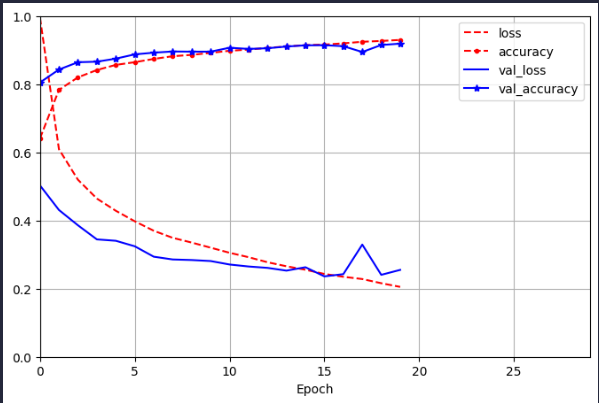


# LeNet-5 CNN Architecture

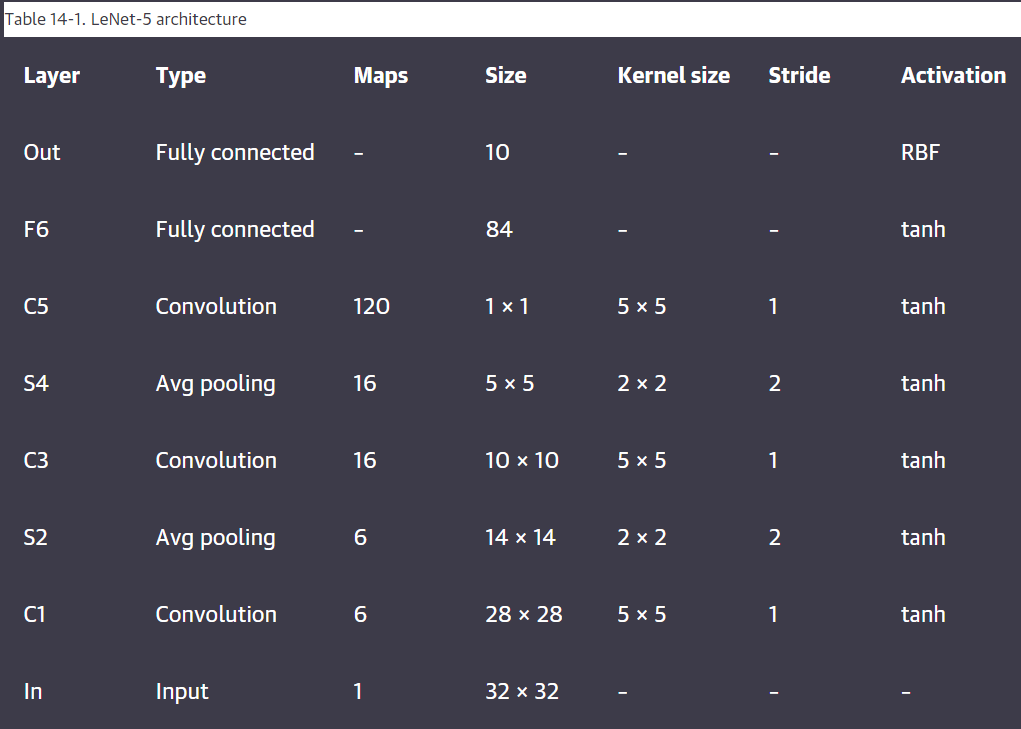

# AlexNet CNN Architecture

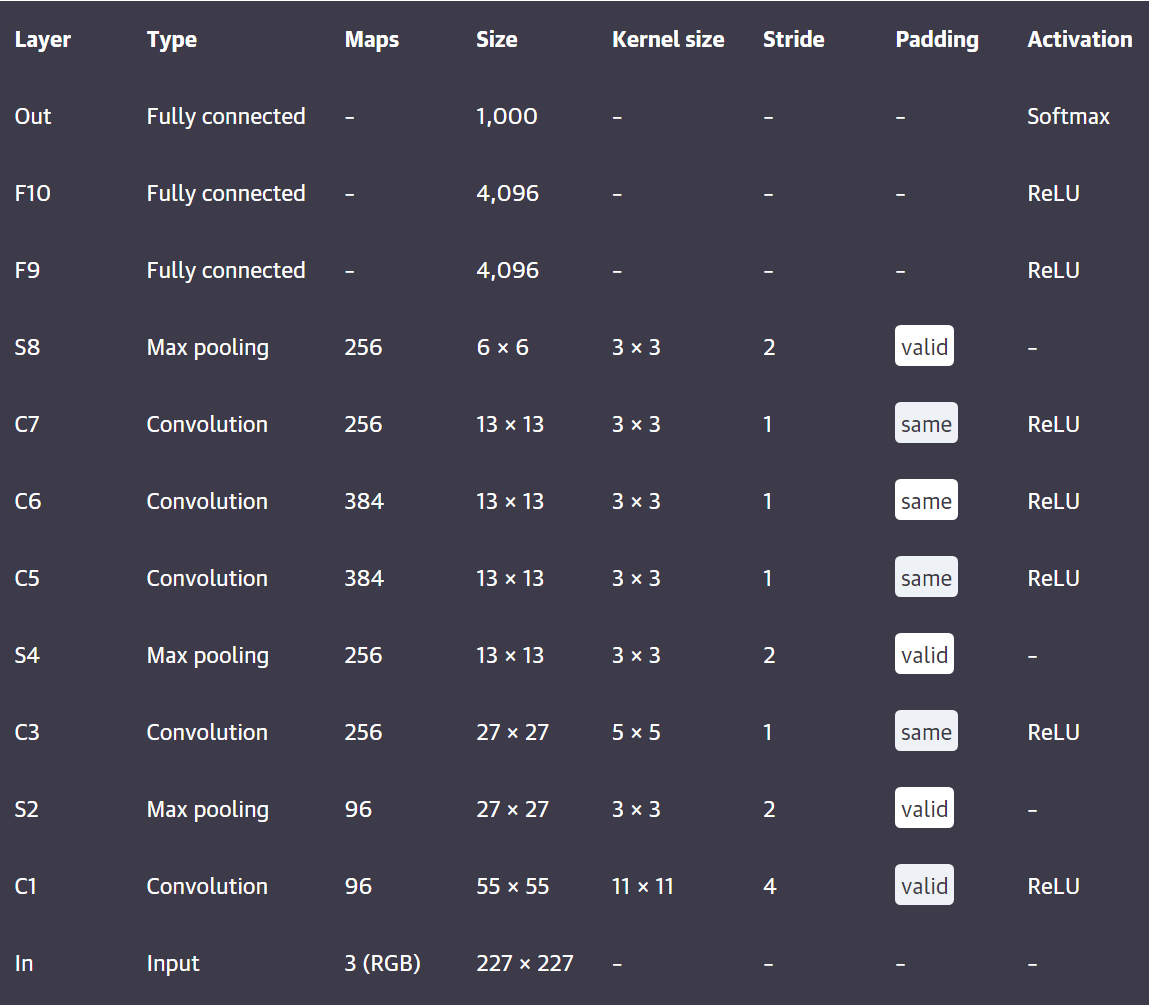